Downloading the data

In [1]:
# Step 1: Download the dataset
import os
import tarfile
import urllib.request

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
file_name = "aclImdb_v1.tar.gz"
urllib.request.urlretrieve(url, file_name)

# Step 2: Extract the tar.gz file
if file_name.endswith("tar.gz"):
    with tarfile.open(file_name, "r:gz") as tar:
        tar.extractall()

# Step 3: Remove the 'unsup' directory (Windows-compatible)
unsup_dir = "aclImdb/train/unsup"

# Check if directory exists before removing it
if os.path.exists(unsup_dir):
    import shutil
    shutil.rmtree(unsup_dir)

print("Dataset downloaded, extracted, and 'unsup' directory removed.")


Dataset downloaded, extracted, and 'unsup' directory removed.


In [2]:
#!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
#!tar -xf aclImdb_v1.tar.gz
#!rm -r aclImdb/train/unsup

Preparing the data

In [3]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    # Add exist_ok=True to avoid the error if the directory already exists to re run code
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### Base Model

Preparing integer sequence datasets

In [4]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

A sequence model built on one-hot encoded vector sequences

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define max_tokens
max_tokens = 20000

# Define model
inputs = tf.keras.Input(shape=(None,), dtype="int64")
# Embed each integer token using an Embedding layer
# This will give you a 3D tensor (batch_size, sequence_length, embedding_dim)
embedded = layers.Embedding(input_dim=max_tokens, output_dim=128)(inputs)
# Now the output of the embedding layer is 3D, suitable for the LSTM
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 128)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,601,281 (9.92 MB)

 Trainable params: 2,601,281 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

Training a first basic sequence model

In [6]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.6270 - loss: 0.6231 - val_accuracy: 0.8442 - val_loss: 0.3838
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.8407 - loss: 0.4059 - val_accuracy: 0.8342 - val_loss: 0.3762
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.8789 - loss: 0.3258 - val_accuracy: 0.8570 - val_loss: 0.3690
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.8861 - loss: 0.3112 - val_accuracy: 0.8864 - val_loss: 0.3070
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.9136 - loss: 0.2503 - val_accuracy: 0.8802 - val_loss: 0.3472
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9258 - loss: 0.2142 - val_accuracy: 0.8608 - val_loss: 0.4014
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9349 - loss: 0.1926 - val_accuracy: 0.8740 - val_loss: 0.3380
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9448 - loss: 0.1643 - 

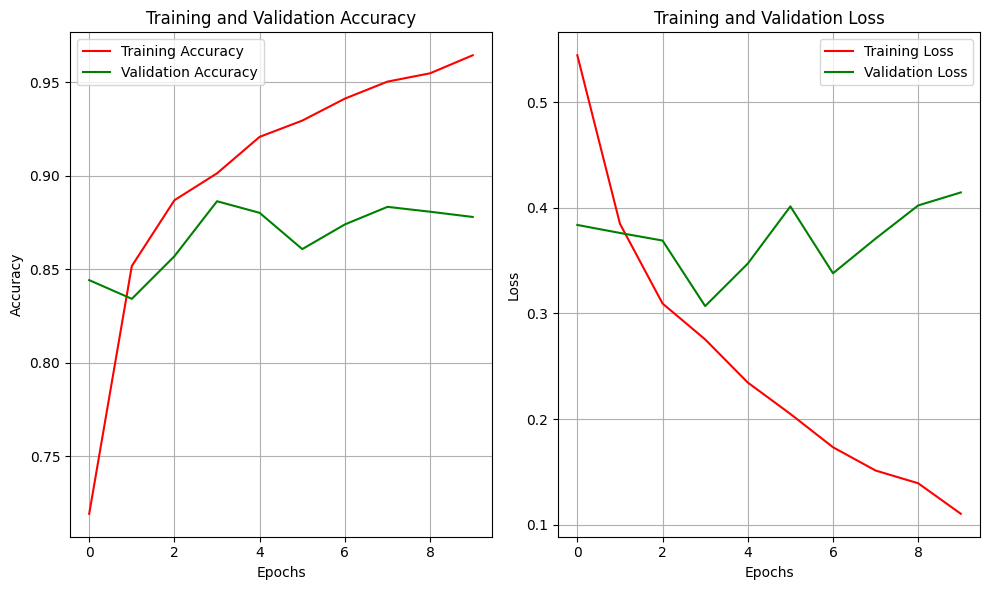

In [9]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  # Add grid lines

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='red', label='Training Loss')
plt.plot(history.history['val_loss'], color='green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid lines

plt.tight_layout()
plt.show()


### Question 1

In [10]:
max_length_150 = 150
text_vectorization_150 = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length_150, #This ensure the review is turncated to exactly 150 tokens
)
text_vectorization_150.adapt(text_only_train_ds)

# Apply vectorization to train, validation, and test datasets
int_train_ds_150 = train_ds.map(
    lambda x, y: (text_vectorization_150(x), y),
    num_parallel_calls=4)
int_val_ds_150 = val_ds.map(
    lambda x, y: (text_vectorization_150(x), y),
    num_parallel_calls=4)
int_test_ds_150 = test_ds.map(  # Apply the same vectorization to test data
    lambda x, y: (text_vectorization_150(x), y),
    num_parallel_calls=4)


# Define the model
model_cutoff_150 = tf.keras.Sequential([
    layers.Embedding(max_tokens, 128, input_length=max_length_150),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
model_cutoff_150.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

checkpoint_callback = keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm_150.keras", save_best_only=True)

history_150 = model_cutoff_150.fit(
    int_train_ds_150,
    validation_data=int_val_ds_150,
    epochs=10,
    callbacks=[checkpoint_callback]
)

# Evaluate and print accuracy on the test dataset
print(f"Test acc: {model_cutoff_150.evaluate(int_test_ds_150)[1]:.3f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.6255 - loss: 0.6254 - val_accuracy: 0.8342 - val_loss: 0.3910
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8366 - loss: 0.3943 - val_accuracy: 0.8540 - val_loss: 0.3414
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8765 - loss: 0.3202 - val_accuracy: 0.8216 - val_loss: 0.4320
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8985 - loss: 0.2661 - val_accuracy: 0.8466 - val_loss: 0.3843
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9204 - loss: 0.2265 - val_accuracy: 0.8470 - val_loss: 0.4065
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9356 - loss: 0.1853 - val_accuracy: 0.8480 - val_loss: 0.4778
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9447 - loss: 0.1585 - val_accuracy: 0.8486 - val_loss: 0.5310
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9586 - loss: 0.1236 - val_accurac

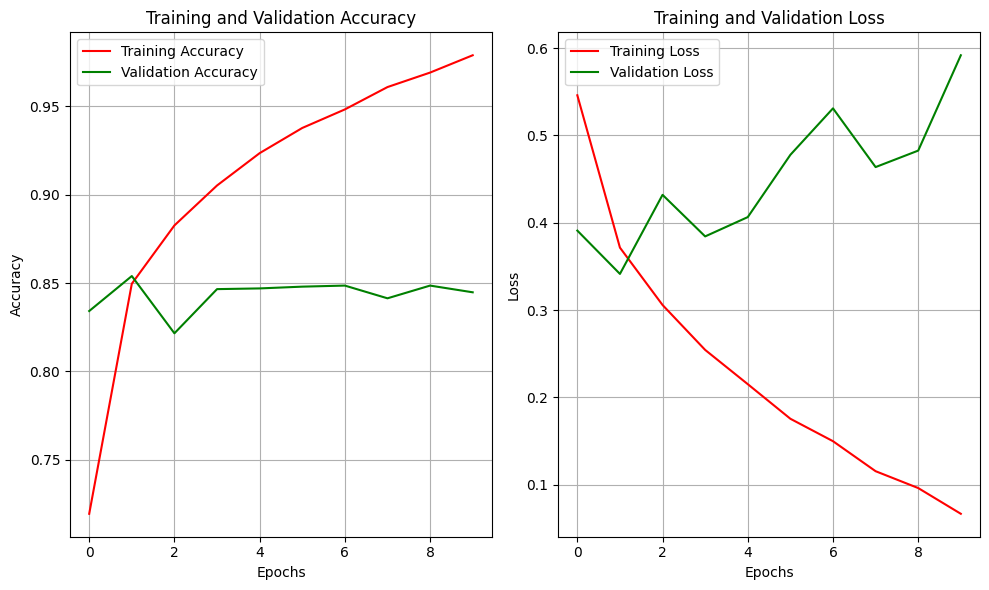

In [11]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_150.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history_150.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  # Add grid lines

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_150.history['loss'], color='red', label='Training Loss')
plt.plot(history_150.history['val_loss'], color='green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid lines

plt.tight_layout()
plt.show()


### Question 2

In [12]:
int_train_ds_small = int_train_ds.take(100) # Limit training samples to 100

# Define model
model_100_samples = tf.keras.Sequential([
    layers.Embedding(max_tokens, 128, input_length=max_length),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

model_100_samples.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model and capture the training history
history_100_samples = model_100_samples.fit(
    int_train_ds_small,
    validation_data=int_val_ds,
    epochs=10
)

print(f"Test acc: {model_100_samples.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.5092 - loss: 0.6938 - val_accuracy: 0.5990 - val_loss: 0.6847
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.6388 - loss: 0.6497 - val_accuracy: 0.7566 - val_loss: 0.5519
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.7718 - loss: 0.5119 - val_accuracy: 0.7806 - val_loss: 0.4912
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8333 - loss: 0.4034 - val_accuracy: 0.8016 - val_loss: 0.4465
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.8969 - loss: 0.3081 - val_accuracy: 0.8090 - val_loss: 0.4421
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9147 - loss: 0.2459 - val_accuracy: 0.7946 - val_loss: 0.4775
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9461 - loss: 0.1796 - val_accuracy: 0.7852 - val_loss: 0.5100
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9526 - loss: 0.1693 - val_acc

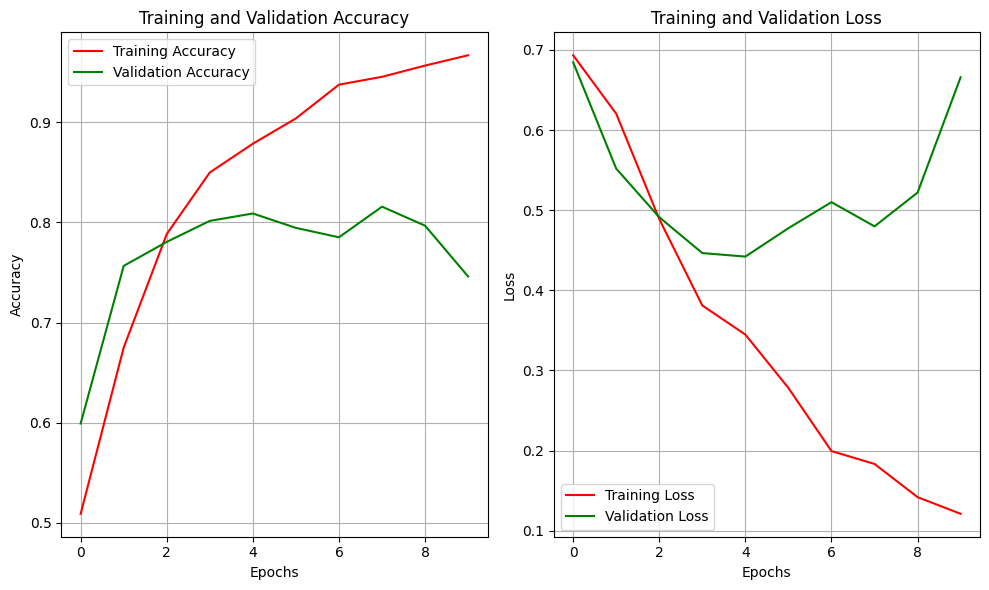

In [13]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_100_samples.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history_100_samples.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_100_samples.history['loss'], color='red', label='Training Loss')
plt.plot(history_100_samples.history['val_loss'], color='green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Question 3

In [14]:
# Limit validation dataset to 10,000 samples
int_val_ds_10k = int_val_ds.take(10000)

# Define model
model_validate_10k = tf.keras.Sequential([
    layers.Embedding(max_tokens, 128, input_length=max_length),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
model_validate_10k.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

history_validate_10k = model_validate_10k.fit(
    int_train_ds,
    validation_data=int_val_ds_10k,
    epochs=10
)

# Evaluate and print accuracy on the test dataset
print(f"Test acc: {model_validate_10k.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6413 - loss: 0.6145 - val_accuracy: 0.8214 - val_loss: 0.4124
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8374 - loss: 0.4045 - val_accuracy: 0.8536 - val_loss: 0.3482
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8759 - loss: 0.3294 - val_accuracy: 0.8732 - val_loss: 0.3281
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9036 - loss: 0.2758 - val_accuracy: 0.8790 - val_loss: 0.3210
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.9143 - loss: 0.2402 - val_accuracy: 0.8748 - val_loss: 0.3322
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9268 - loss: 0.2154 - val_accuracy: 0.8718 - val_loss: 0.3747
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9328 - loss: 0.1951 - val_accuracy: 0.8498 - val_loss: 0.3985
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9433 - loss: 0.1720 - 

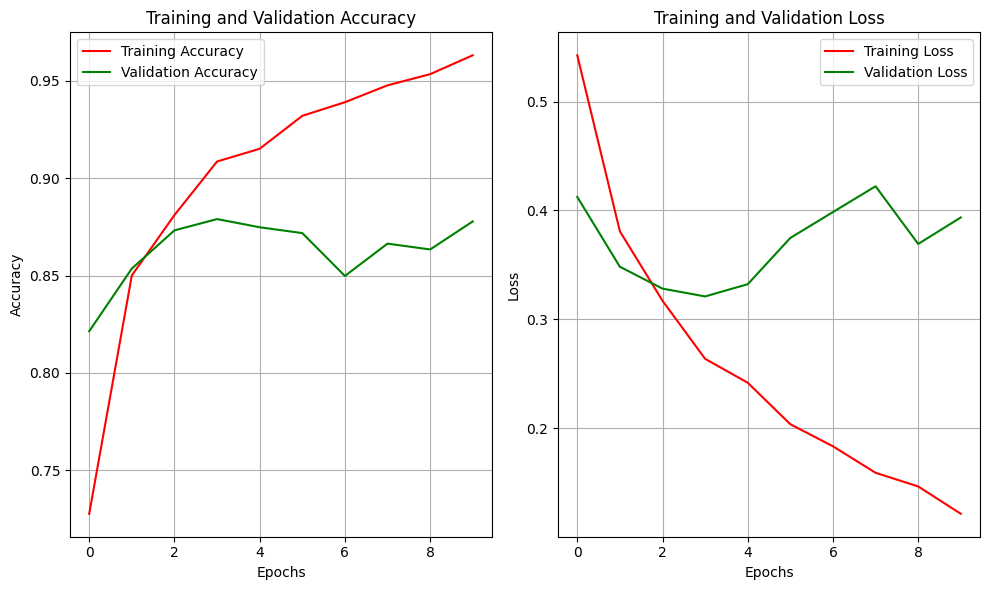

In [15]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_validate_10k.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history_validate_10k.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  # Enable grid lines

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_validate_10k.history['loss'], color='red', label='Training Loss')
plt.plot(history_validate_10k.history['val_loss'], color='green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Enable grid lines

plt.tight_layout()
plt.show()


### Question 4

In [16]:
# Adjust max_tokens to 10,000
max_tokens_10k = 10000
text_vectorization_10k = layers.TextVectorization(
    max_tokens=max_tokens_10k,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization_10k.adapt(text_only_train_ds)

# Transform datasets with the updated vectorizer
int_train_ds_10k = train_ds.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)
int_val_ds_10k = val_ds.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)
int_test_ds_10k = test_ds.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)

# Define model
model_top_10k = tf.keras.Sequential([
    layers.Embedding(max_tokens_10k, 128, input_length=max_length),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
model_top_10k.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model and capture the training history
history_top_10k = model_top_10k.fit(
    int_train_ds_10k,
    validation_data=int_val_ds_10k,
    epochs=10
)

# Evaluate and print accuracy on the test dataset
print(f"Test acc: {model_top_10k.evaluate(int_test_ds_10k)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6054 - loss: 0.6342 - val_accuracy: 0.8456 - val_loss: 0.3830
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8328 - loss: 0.4137 - val_accuracy: 0.8480 - val_loss: 0.3571
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8684 - loss: 0.3500 - val_accuracy: 0.8464 - val_loss: 0.3680
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8914 - loss: 0.2889 - val_accuracy: 0.8692 - val_loss: 0.3759
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9024 - loss: 0.2667 - val_accuracy: 0.8786 - val_loss: 0.3133
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9168 - loss: 0.2327 - val_accuracy: 0.8650 - val_loss: 0.3813
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9289 - loss: 0.2043 - val_accuracy: 0.8722 - val_loss: 0.3579
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9354 - loss: 0.1863 - 

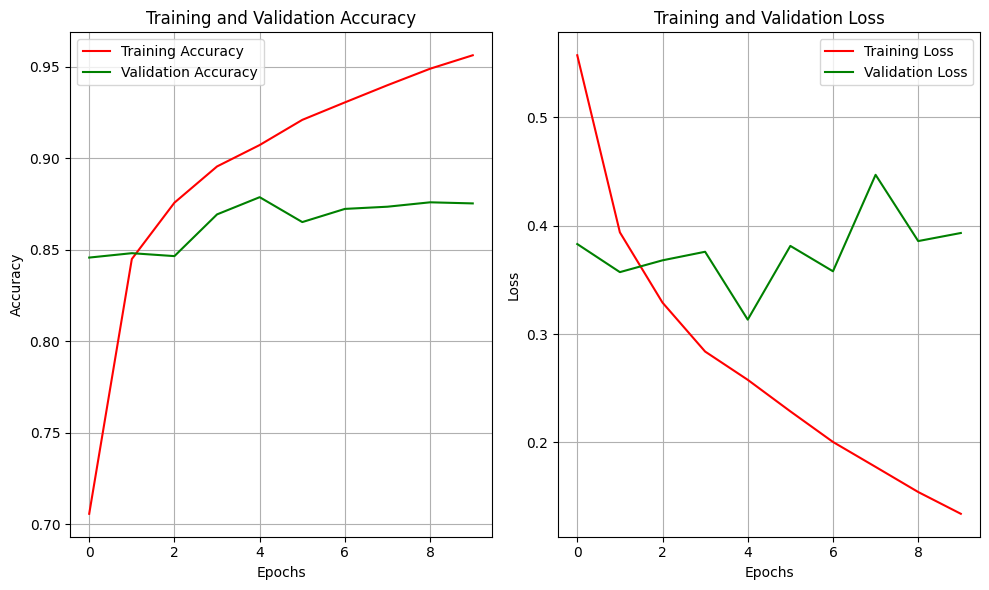

In [17]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_top_10k.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history_top_10k.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_top_10k.history['loss'], color='red', label='Training Loss')
plt.plot(history_top_10k.history['val_loss'], color='green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Question 5

Preparing pre trained model

In [18]:
import os
import tarfile
import urllib.request
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers

# Step 1: Download the dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
file_name = "aclImdb_v1.tar.gz"
urllib.request.urlretrieve(url, file_name)

# Step 2: Extract the tar.gz file
if file_name.endswith("tar.gz"):
    with tarfile.open(file_name, "r:gz") as tar:
        tar.extractall()

# Step 3: Remove the 'unsup' directory (Windows-compatible)
unsup_dir = "aclImdb/train/unsup"
if os.path.exists(unsup_dir):
    import shutil
    shutil.rmtree(unsup_dir)

print("Dataset downloaded, extracted, and 'unsup' directory removed.")

# Step 4: Load GloVe embeddings
path_to_glove_file = "glove.6B.100d.txt"
embeddings_index = {}
if os.path.exists(path_to_glove_file):
    with open(path_to_glove_file, encoding="utf-8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")
else:
    print("GloVe embeddings file not found. Please download it and place it in the working directory.")

# Step 5: Prepare vocabulary and embedding matrix
# Example TextVectorization layer
max_tokens = 20000  # Maximum number of words in the vocabulary
max_length = 200  # Maximum length of input sequences
text_vectorization = layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=max_length)

# Simulating a vocabulary (replace with your actual vocabulary from `text_vectorization`)
vocabulary = ["the", "and", "movie", "good", "bad", "great"]  # Example
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Initialize embedding matrix
embedding_dim = 100  # Must match the GloVe file dimension
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 6: Define embedding layers
# a) Embedding layer with learned embeddings
embedding_layer_trained = layers.Embedding(
    max_tokens,
    embedding_dim,
    input_length=max_length
)

# b) Pretrained embedding layer using GloVe (frozen)
embedding_layer_pretrained = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    trainable=False,  # Freeze embeddings
    mask_zero=True
)

print("Embedding layers defined.")


Dataset downloaded, extracted, and 'unsup' directory removed.
GloVe embeddings file not found. Please download it and place it in the working directory.
Embedding layers defined.


In [19]:
# Define the model with the learned embedding layer
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = embedding_layer_trained(inputs)  # Trained embedding
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_trained = tf.keras.Model(inputs, outputs)
model_trained.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model and capture the training history
history_trained = model_trained.fit(int_train_ds, validation_data=int_val_ds, epochs=10)

# Evaluate and print accuracy on the test dataset
print(f"Test acc (Trained Embedding): {model_trained.evaluate(int_test_ds)[1]:.3f}")


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6304 - loss: 0.6225 - val_accuracy: 0.8184 - val_loss: 0.4140
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8404 - loss: 0.4029 - val_accuracy: 0.8410 - val_loss: 0.4145
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8761 - loss: 0.3284 - val_accuracy: 0.8076 - val_loss: 0.5117
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.8989 - loss: 0.2759 - val_accuracy: 0.8738 - val_loss: 0.4046
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.9132 - loss: 0.2486 - val_accuracy: 0.8556 - val_loss: 0.3884
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9226 - loss: 0.2219 - val_accuracy: 0.8632 - val_loss: 0.3713
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9344 - loss: 0.1917 - val_accuracy: 0.8796 - val_loss: 0.3417
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9417 - loss: 0.1716 - 

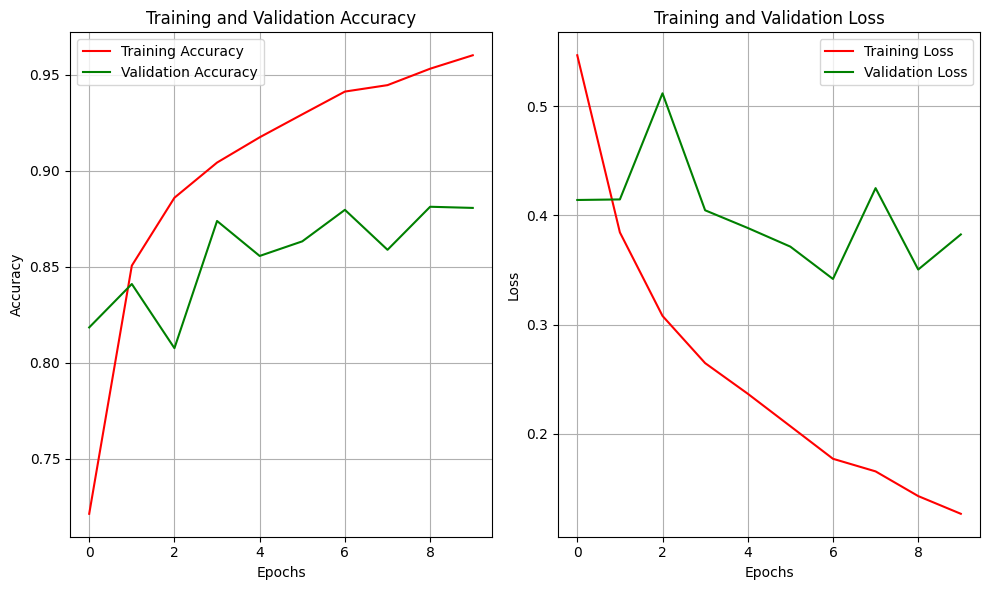

In [20]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_trained.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history_trained.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_trained.history['loss'], color='red', label='Training Loss')
plt.plot(history_trained.history['val_loss'], color='green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [21]:
import requests
import zipfile
import os

# Download the file
url = "http://nlp.stanford.edu/data/glove.6B.zip"
output_path = "glove.6B.zip"

print("Downloading Glove embeddings...")
response = requests.get(url)
with open(output_path, "wb") as file:
    file.write(response.content)

# Extract the zip file
print("Extracting the zip file...")
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(".")

# Cleanup: Optional
os.remove(output_path)
print("Download and extraction complete.")


Extracting the zip file...
Download and extraction complete.


In [22]:
import numpy as np

# Path to the GloVe embeddings file
path_to_glove_file = "glove.6B.100d.txt"  # Update the path if needed

# Dictionary to store word embeddings
embeddings_index = {}

try:
    print("Loading GloVe embeddings...")
    with open(path_to_glove_file, encoding="utf-8") as f:
        for line in f:
            # Split each line into the word and its coefficients
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")  # Convert coefficients to numpy array
            embeddings_index[word] = coefs  # Add to dictionary

    print(f"Found {len(embeddings_index)} word vectors.")
except FileNotFoundError:
    print(f"Error: File not found at {path_to_glove_file}. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")


Loading GloVe embeddings...
Found 400000 word vectors.


In [23]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np

# Parameters
max_tokens = 20000  # Adjust according to your dataset/vocabulary size
embedding_dim = 100  # Dimension of GloVe embeddings
batch_size = 32  # Adjust batch size according to your system

# Step 1: Load GloVe embeddings
embeddings_index = {}
path_to_glove_file = "glove.6B.100d.txt"
with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

# Step 2: Load your dataset (using keras text_dataset_from_directory)
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

# Step 3: Prepare the TextVectorization layer
# Extract texts from train_ds (text data)
train_texts = train_ds.map(lambda x, y: x)  # Extract only the texts
text_vectorization = layers.TextVectorization(max_tokens=max_tokens)
text_vectorization.adapt(train_texts)  # Adapt to your training data

# Prepare the embedding matrix
vocabulary = text_vectorization.get_vocabulary()  # Vocabulary from your dataset
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 4: Define the embedding layer
embedding_layer_pretrained = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,  # Freeze GloVe weights
    mask_zero=True,  # Optional: Mask padding tokens
)

# Step 5: Preprocess and prepare the datasets
def vectorize_text(text, label):
    return text_vectorization(text), label

train_ds = train_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)

# Step 6: Build the model
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = embedding_layer_pretrained(inputs)  # Use pretrained GloVe embeddings
x = layers.Bidirectional(layers.LSTM(32))(x)  # Bidirectional LSTM
x = layers.Dropout(0.5)(x)  # Dropout layer
outputs = layers.Dense(1, activation="sigmoid")(x)  # Output layer for binary classification

model_pretrained = tf.keras.Model(inputs, outputs)

# Step 7: Compile the model
model_pretrained.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),  # Adjust learning rate
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Step 8: Train the model
history_pretrained = model_pretrained.fit(
    train_ds,  # Training dataset (tokenized and batched)
    validation_data=val_ds,  # Validation dataset
    epochs=10  # Number of epochs
)

# Step 9: Evaluate the model
test_loss, test_acc = model_pretrained.evaluate(test_ds)  # Test dataset
print(f"Test Accuracy (Pretrained Embedding): {test_acc:.3f}")


Found 400000 word vectors.
Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5278 - loss: 0.6979 - val_accuracy: 0.6530 - val_loss: 0.6398
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.6669 - loss: 0.6114 - val_accuracy: 0.7366 - val_loss: 0.5352
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.7312 - loss: 0.5405 - val_accuracy: 0.7502 - val_loss: 0.5083
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.7598 - loss: 0.5000 - val_accuracy: 0.7604 - val_loss: 0.4965
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.7793 - loss: 0.4757 - val_accuracy: 0.7984 - val_loss: 0.4507
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.7861 - loss: 0.4596 - val_accuracy: 0.7880 - val_loss: 0.4566
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.

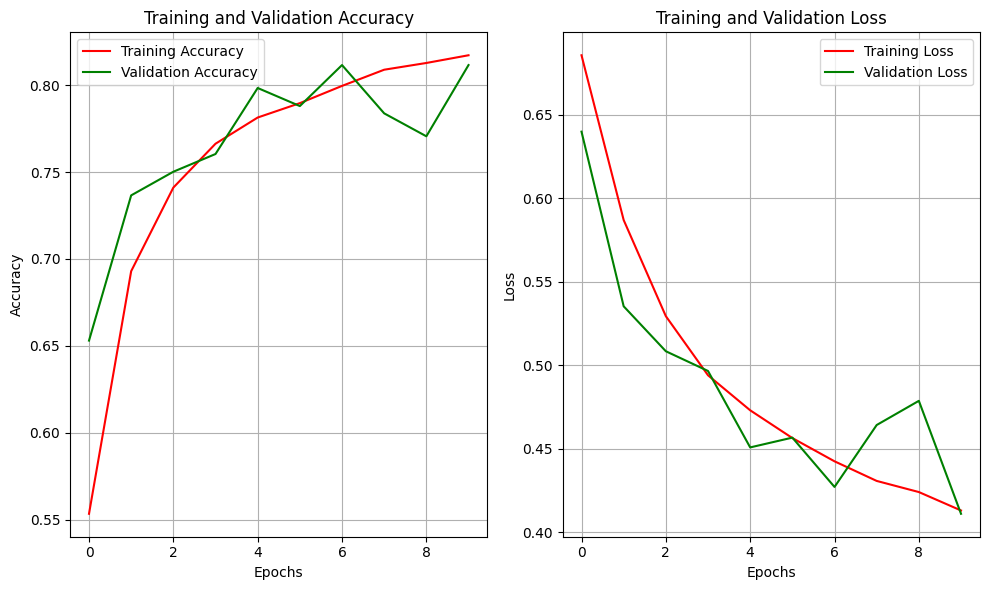

In [24]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_pretrained.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history_pretrained.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['loss'], color='red', label='Training Loss')
plt.plot(history_pretrained.history['val_loss'], color='green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Increasing Values

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5014 - loss: 0.7119 - val_accuracy: 0.5626 - val_loss: 0.6828
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5577 - loss: 0.6834 - val_accuracy: 0.5932 - val_loss: 0.6710
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5974 - loss: 0.6610 - val_accuracy: 0.5998 - val_loss: 0.6638
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6200 - loss: 0.6525 - val_accuracy: 0.6066 - val_loss: 0.6559
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6322 - loss: 0.6374 - val_accuracy: 0.5996 - val_loss: 0.6591
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6491 - loss: 0.6207 - val_accuracy: 0.6092 - val_loss: 0.6506
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6710 - loss: 0.6034 - val_accuracy: 0.6178 - val_loss: 0.6455
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.6666 - loss: 0.6009 - val_acc

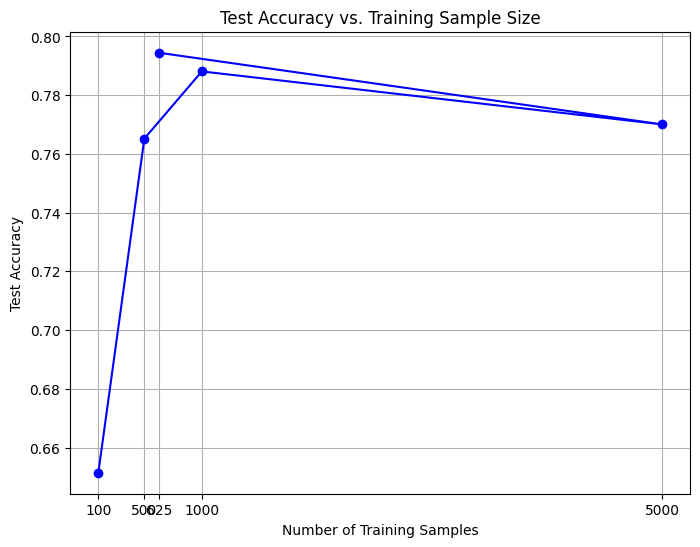

In [25]:
# Define a list of different training sample sizes to test
training_sizes = [100, 500, 1000, 5000, len(int_train_ds)]  # Add the total number of training samples at the end

# Initialize variables to store test accuracy for each training size
test_accuracies = []

for size in training_sizes:
    # Take a subset of the training dataset based on the current size
    subset_train_ds = int_train_ds.take(size)

    # Define the model with the embedding layer (use either learned or pretrained)
    inputs = tf.keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer_pretrained(inputs)  # Use pretrained embedding layer (GloVe) or embedding_layer_trained
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

    # Train the model with the current subset of training data
    model.fit(subset_train_ds, validation_data=int_val_ds, epochs=10)

    # Evaluate the model on the test dataset and store the test accuracy
    test_accuracy = model.evaluate(int_test_ds)[1]
    test_accuracies.append(test_accuracy)

    # Print the test accuracy for the current training size
    print(f"Training samples: {size}, Test accuracy: {test_accuracy:.3f}")

# Print out the test accuracies for all training sizes
print("\nTest accuracies for different training sizes:")
for size, accuracy in zip(training_sizes, test_accuracies):
    print(f"Training size: {size}, Test accuracy: {accuracy:.3f}")

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(training_sizes, test_accuracies, marker='o', linestyle='-', color='b')
plt.title("Test Accuracy vs. Training Sample Size")
plt.xlabel("Number of Training Samples")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.xticks(training_sizes)  # Ensure all training sizes are shown on the x-axis
plt.show()